# Restaurant Recommender System based on LightGCN

## 1. Install Packages and Libraries

In [ ]:
# Install required packages.
%%capture
import torch
import os
os.environ['TORCH'] = torch.__version__
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
# import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch.nn.functional as F
from torch import Tensor, nn, optim
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import negative_sampling, structured_negative_sampling
from torch_sparse import SparseTensor, matmul

## 2. Data Loading and Preprocessing

Google Restaurants Dataset (the filtered subset ~112M)

We read the json file, and transform the data into tensor node embeddings that are suitable for model training

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal_restaurants/filter_all_t.json -O filter_all_t.json

--2024-12-09 07:54:03--  https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal_restaurants/filter_all_t.json
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117893558 (112M) [application/json]
Saving to: ‘filter_all_t.json’

filter_all_t.json   100%[===================>] 112.43M  65.1MB/s    in 1.7s    

2024-12-09 07:54:05 (65.1 MB/s) - ‘filter_all_t.json’ saved [117893558/117893558]



In [ ]:
import json

# Load JSON file
with open('filter_all_t.json', 'r') as file:
    data = json.load(file)

In [ ]:
# The dataset contains train, val, and test sets.
train_data = pd.DataFrame(data["train"])
val_data = pd.DataFrame(data["val"])
test_data = pd.DataFrame(data["test"])

print("The dim of training data:", train_data.shape)
print("The dim of validation data:", val_data.shape)
print("The dim of test data:", test_data.shape)

The dim of training data: (87013, 6)
The dim of validation data: (10860, 6)
The dim of test data: (11015, 6)


In [ ]:
train_data.head()

,business_id,user_id,rating,review_text,pics,history_reviews
0,60567465d335d0abfb415b26,101074926318992653684,4,The tang of the tomato sauce is outstanding. A...,"[AF1QipM-2IRmvitARbcJr7deWfe5hyVBg_ArPMQSYvq0,...",[[101074926318992653684_6056272797d555cc6fb0d1...
1,6050fa9f5b4ccec8d5cae994,117065749986299237881,5,Chicken and waffles were really good!,[AF1QipMpfxIZUT_aymQ3qPGO-QgGYzxbtLZGmHufAp2s],[[117065749986299237881_605206f8d8c08f462b93e8...
2,604be10877e81aaed3cc9a1e,106700937793048450809,4,The appetizer of colossal shrimp was very good...,"[AF1QipMNnqM5X9sSyZ9pXRZ1jvrURHN9bZhGdzuEXoP8,...",[[106700937793048450809_6044300b27f39b7b5d1dbf...
3,60411e017cd8bf130362365a,101643045857250355161,5,The fish tacos here omg! The salad was great ...,"[AF1QipM-a6AGGp4Hgk5RD0gY5sDRp5kEfB1hZLvlRkft,...",[[101643045857250355161_604fbdd099686c10168c91...
4,604139dd7cd8bf1303624208,109802745326785766951,4,"Ribs are great, as are the mac and cheese, fri...",[AF1QipNVys4yq-5w_3EsDdHpSc9ZNb7Nl30Mfb6Y0Gup],[[109802745326785766951_60524fa9f09a4ffff042f9...


In [ ]:
def preprocessing(data):
  '''
  Args:
    data (pd.DataFrame)
  Returns:
    data (pd.DataFrame)
    user_id_map (dict)
    business_id_map (dict)
  '''
  # Create a dictionary mapping user_id to consecutive values [0,..., n]
  user_id_map = {idx: i for i, idx in enumerate(data["user_id"].unique())}
  # Create a dictionary mapping business_id to consecutive values [0,..., m]
  business_id_map = {idx: i for i, idx in enumerate(data["business_id"].unique())}

  # Extend the dataframe with new ids
  data["u_id"] = data["user_id"].map(user_id_map)
  data["b_id"] = data["business_id"].map(business_id_map)
  data["r_id"] = data.index

  return data, user_id_map, business_id_map

In [ ]:
train_data, train_user_id_map, train_business_id_map = preprocessing(train_data)
val_data, val_user_id_map, val_business_id_map = preprocessing(val_data)
test_data, test_user_id_map, test_business_id_map = preprocessing(test_data)

all_data = pd.concat([train_data, val_data, test_data])
all_data, all_user_id_map, all_business_id_map = preprocessing(all_data)

train_num_users, train_num_businesses = len(train_user_id_map), len(train_business_id_map)
val_num_users, val_num_businesses = len(val_user_id_map), len(val_business_id_map)
test_num_users, test_num_businesses = len(test_user_id_map), len(test_business_id_map)
num_users, num_businesses = len(all_user_id_map), len(all_business_id_map)

print("=============== Training Data ===============")
print("The number of users in training data: ", train_num_users)
print("The number of businesses in training data: ", train_num_businesses)
print("=============== Validation Data ===============")
print("The number of users in validation data: ", val_num_users)
print("The number of businesses in validation data: ", val_num_businesses)
print("=============== Test Data ===============")
print("The number of users in test data: ", test_num_users)
print("The number of businesses in test data: ", test_num_businesses)
print("=============== All Data ===============")
print("The number of users in all data: ", num_users)
print("The number of businesses in training data: ", num_businesses)


=============== Training Data ===============
The number of users in training data:  29596
The number of businesses in training data:  27896
=============== Validation Data ===============
The number of users in validation data:  3700
The number of businesses in validation data:  7835
=============== Test Data ===============
The number of users in test data:  3700
The number of businesses in test data:  7880
=============== All Data ===============
The number of users in all data:  36996
The number of businesses in training data:  30831


In [ ]:
# write code to check if val_data['business_id'] is in train_data['business_id']
print(len(set(val_data['business_id']) - set(train_data['business_id'])))
print(len(set(val_data['business_id'])))
print(len(set(train_data['business_id'])))

print(len(set(val_data['user_id']) - set(train_data['user_id'])))
print(len(set(val_data['user_id'])))
print(len(set(train_data['user_id'])))

1553
7835
27896
3700
3700
29596


In [ ]:
print(len(set(test_data['business_id']) - set(train_data['business_id'])))
print(len(set(test_data['business_id'])))
print(len(set(train_data['business_id'])))
print(len(set(val_data['user_id']) - set(train_data['user_id'])))
print(len(set(val_data['user_id'])))
print(len(set(train_data['user_id'])))

1558
7880
27896
3700
3700
29596


In [ ]:
def generate_edge_index(data, user_id_map, business_id_map):
  '''
  Args:
    data              (pd.DataFrame)
    user_id_map       (dict)
    business_id_map   (dict)
  Returns:
    edge_index        (torch.tensor)
    edge_index_sparse (SparseTensor)
  '''
  ##############################################################################
  # Generate edge_index and edge_index_sparse (adjacency matrix)
  # For now, we assume there is only one edge type between user and business, i.e. review (interaction)
  # TODO: segregate reviews into different groups based on review text sentiment and/or rating (positive/neutral/negative)
  ##############################################################################
  edge_index = [[],[]] # dim = 2 x (# of reviews)
  for i in range(len(data)):
    edge_index[0].append(user_id_map[data["user_id"][i]])
    edge_index[1].append(business_id_map[data["business_id"][i]] + len(user_id_map))
  edge_index = torch.tensor(edge_index)

  num_nodes = num_users + num_businesses
  edge_index_sparse = SparseTensor(
      row=torch.tensor(edge_index[0]),
      col=torch.tensor(edge_index[1]),
      sparse_sizes=(num_nodes, num_nodes))
  return edge_index, edge_index_sparse

In [ ]:
num_users, num_businesses = len(train_user_id_map), len(train_business_id_map)

num_nodes = num_users + num_businesses

In [ ]:
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

train_edge_index, train_edge_index_sparse = generate_edge_index(train_data, train_user_id_map, train_business_id_map)

train_num_users, train_num_businesses = len(train_user_id_map), len(train_business_id_map)

num_users, num_businesses = len(train_user_id_map), len(train_business_id_map)

num_nodes = num_users + num_businesses

graph_data = Data(edge_index = train_edge_index, num_nodes = num_nodes)

# convert to train/val/test splits
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0.15, num_test=0.15
)
train_split, val_split, test_split = transform(graph_data)

<ipython-input-9-fc709e669145>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row=torch.tensor(edge_index[0]),
<ipython-input-9-fc709e669145>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  col=torch.tensor(edge_index[1]),


In [ ]:
# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 60911 positive supervision edges
Validation set has 13051 positive supervision edges
Test set has 13051 positive supervision edges
Train set has 121822 message passing edges
Validation set has 121822 message passing edges
Test set has 147924 message passing edges


### Try something

In [ ]:
n_playlists = num_users
n_tracks = num_businesses

In [ ]:
# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

In [ ]:
class GCN(torch.nn.Module):
    """
      Here we adapt the LightGCN model from Torch Geometric for our purposes. We allow
      for customizable convolutional layers, custom embeddings. In addition, we deifne some
      additional custom functions.

    """

    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable = False,
        conv_layer = "LGC",
        name = None,
        **kwargs,
    ):
        super().__init__()
        alpha_string = "alpha" if alpha_learnable else ""
        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        if alpha_learnable == True:
          alpha_vals = torch.rand(num_layers+1)
          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))
          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")
        else:
          if alpha is None:
              alpha = 1. / (num_layers + 1)

          if isinstance(alpha, Tensor):
              assert alpha.size(0) == num_layers + 1
          else:
              alpha = torch.tensor([alpha] * (num_layers + 1))

        self.register_buffer('alpha', alpha)

        self.embedding = Embedding(num_nodes, embedding_dim)

        # initialize convolutional layers
        self.conv_layer = conv_layer
        if conv_layer == "LGC":
          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])
        elif conv_layer == "GAT":
          # initialize Graph Attention layer with multiple heads
          # initialize linear layers to aggregate heads
          n_heads = 5
          self.convs = ModuleList(
              [GATConv(in_channels = embedding_dim, out_channels = embedding_dim, heads = n_heads, dropout = 0.5, **kwargs) for _ in range(num_layers)]
          )
          self.linears = ModuleList([Linear(n_heads * embedding_dim, embedding_dim) for _ in range(num_layers)])

        elif conv_layer == "SAGE":
          #  initialize GraphSAGE conv
          self.convs = ModuleList(
              [SAGEConv(in_channels = embedding_dim, out_channels = embedding_dim, **kwargs) for _ in range(num_layers)]
          )

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight

        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if self.conv_layer == "GAT":
              x = self.linears[i](x)
            out = out + x * weights[i + 1]

        return out

    def initialize_embeddings(self, data):
      # initialize with the data node features
        self.embedding.weight.data.copy_(data.node_feature)


    def forward(self, edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            if isinstance(edge_index, SparseTensor):
                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)
            else:
                edge_label_index = edge_index

        out = self.get_embedding(edge_index)

        return self.predict_link_embedding(out, edge_label_index)

    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,
                     prob: bool = False) -> Tensor:

        pred = self(edge_index, edge_label_index).sigmoid()
        return pred if prob else pred.round()

    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor:

        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        return (embed_src * embed_dst).sum(dim=-1)


    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        out_src = out_dst = self.get_embedding(edge_index)

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:  # Map local top-indices to original indices.
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,
                       **kwargs) -> Tensor:
        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)
        return loss_fn(pred, edge_label.to(pred.dtype))


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        r"""Computes the model loss for a ranking objective via the Bayesian
        Personalized Ranking (BPR) loss."""
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)

    def bpr_loss(self, pos_scores, neg_scores):
      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.num_nodes}, '
                f'{self.embedding_dim}, num_layers={self.num_layers})')

In [ ]:
class BPRLoss(_Loss):
    r"""The Bayesian Personalized Ranking (BPR) loss.

    The BPR loss is a pairwise loss that encourages the prediction of an
    observed entry to be higher than its unobserved counterparts
    (see `here <https://arxiv.org/abs/2002.02126>`__).

    .. math::
        L_{\text{BPR}} = - \sum_{u=1}^{M} \sum_{i \in \mathcal{N}_u}
        \sum_{j \not\in \mathcal{N}_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj})
        + \lambda \vert\vert \textbf{x}^{(0)} \vert\vert^2

    where :math:`lambda` controls the :math:`L_2` regularization strength.
    We compute the mean BPR loss for simplicity.

    Args:
        lambda_reg (float, optional): The :math:`L_2` regularization strength
            (default: 0).
        **kwargs (optional): Additional arguments of the underlying
            :class:`torch.nn.modules.loss._Loss` class.
    """
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        r"""Compute the mean Bayesian Personalized Ranking (BPR) loss.

        .. note::

            The i-th entry in the :obj:`positives` vector and i-th entry
            in the :obj:`negatives` entry should correspond to the same
            entity (*.e.g*, user), as the BPR is a personalized ranking loss.

        Args:
            positives (Tensor): The vector of positive-pair rankings.
            negatives (Tensor): The vector of negative-pair rankings.
            parameters (Tensor, optional): The tensor of parameters which
                should be used for :math:`L_2` regularization
                (default: :obj:`None`).
        """
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)

        return (-log_prob + regularization) / n_pairs

In [ ]:
def sample_negative_edges(data, num_playlists, num_tracks, device=None):
    positive_playlists, positive_tracks = data.edge_label_index

    # Create a mask tensor with the shape (num_playlists, num_tracks)
    mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    mask[positive_playlists, positive_tracks - num_playlists] = True

    # Flatten the mask tensor and get the indices of the negative edges
    flat_mask = mask.flatten()
    negative_indices = torch.where(~flat_mask)[0]

    # Sample negative edges from the negative_indices tensor
    sampled_negative_indices = negative_indices[
        torch.randint(0, negative_indices.size(0), size=(positive_playlists.size(0),), device=device)
    ]

    # Convert the indices back to playlists and tracks tensors
    playlists = torch.floor_divide(sampled_negative_indices, num_tracks)
    tracks = torch.remainder(sampled_negative_indices, num_tracks)
    tracks = tracks + num_playlists

    neg_edge_index = torch.stack((playlists, tracks), dim=0)
    neg_edge_label = torch.zeros(neg_edge_index.shape[1], device=device)

    return neg_edge_index, neg_edge_label

In [ ]:
def recall_at_k(data, model, k = 300, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[n_playlists:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

In [ ]:
from sklearn.metrics import roc_auc_score
def metrics(labels, preds):
  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
  return roc

In [ ]:
# Train
def train(datasets, model, optimizer, loss_fn, args, neg_samp = "random"):
  print(f"Beginning training for {model.name}")

  train_data = datasets["train"]
  val_data = datasets["val"]

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'roc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]): # loop over each epoch
    model.train()
    optimizer.zero_grad()

    # obtain negative sample
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(train_data, num_users, num_businesses, args["device"])

    # calculate embedding
    embed = model.get_embedding(train_data.edge_index)
    # calculate pos, negative scores using embedding
    pos_scores = model.predict_link_embedding(embed, train_data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)

    # calculate loss function
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    train_roc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_neg_edge, val_neg_label = test(
        model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label
    )

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")

    if epoch % 10 == 0:
      # calculate recall @ K
      val_recall = recall_at_k(val_data, model, k = 300, device = args["device"])
      print(f"Val recall {val_recall}")
      stats['val']['recall'].append(val_recall)

    if epoch % 20 == 0:

      # save embeddings for future visualization
      path = os.path.join("model_embeddings", model.name)
      if not os.path.exists(path):
        os.makedirs(path)
      torch.save(model.embedding.weight, os.path.join("model_embeddings", model.name, f"{model.name}_{loss_fn}_{neg_samp}_{epoch}.pt"))

  return stats

def test(model, data, loss_fn, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None):

  model.eval()
  with torch.no_grad(): # want to save RAM

    # conduct negative sampling
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(data, num_users, num_businesses, args["device"])

    # obtain model embedding
    embed = model.get_embedding(data.edge_index)
    # calculate pos, neg scores using embedding
    pos_scores = model.predict_link_embedding(embed, data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)
    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)
    # calculate loss
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    roc = metrics(labels, scores)

  return loss, roc, neg_edge_index, neg_edge_label

In [ ]:
# create a dictionary of the dataset splits
datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}

In [ ]:
# initialize our arguments
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  3,
    'emb_size' : 64,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 301
}

In [ ]:
# initialize model and and optimizer
model = GCN(
    num_nodes = num_nodes, num_layers = args['num_layers'],
    embedding_dim = args["emb_size"], conv_layer = "LGC"
)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [ ]:
datasets['train'].to(args['device'])
datasets['val'].to(args['device'])
datasets['test'].to(args['device'])
model.to(args["device"])

GCN(57492, 64, num_layers=3)

In [ ]:
train(datasets, model, optimizer, "BPR", args, neg_samp = "random")

Beginning training for LGCN_LGC_3_e64_nodes57492_
Epoch 0; Train loss 0.6930004358291626; Val loss 0.6931406259536743; Train ROC 0.9759589919816611; Val ROC 0.5164678684820525
Val recall 0.65614914894104
Epoch 1; Train loss 0.6928196549415588; Val loss 0.6930937170982361; Train ROC 0.998071464050684; Val ROC 0.5254031294485886
Epoch 2; Train loss 0.6919453144073486; Val loss 0.6929563283920288; Train ROC 0.9993645481853293; Val ROC 0.5404252601123636
Epoch 3; Train loss 0.6898828148841858; Val loss 0.6926974058151245; Train ROC 0.9996059223936682; Val ROC 0.5494661815486876
Epoch 4; Train loss 0.6861544847488403; Val loss 0.6922910809516907; Train ROC 0.9993859070257233; Val ROC 0.5539210675487201
Epoch 5; Train loss 0.6803699135780334; Val loss 0.6916607618331909; Train ROC 0.9992409550665163; Val ROC 0.5587480137877725
Epoch 6; Train loss 0.6722613573074341; Val loss 0.6908628940582275; Train ROC 0.9988358574203289; Val ROC 0.5613677646539232
Epoch 7; Train loss 0.6616120338439941; V

{'train': {'loss': [tensor(0.6930, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6928, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6919, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6899, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6862, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6804, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6723, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6616, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6484, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6326, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6142, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5935, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5707, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5463, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5203, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.4937, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.4665, devic

### End try

In [ ]:
# Generate a dictionary with key being user and value being positive items for the user
def get_user_positive_items(edge_index: Tensor):
    '''
    Args:
        edge_index (torch.Tensor): 2 by N list of edges
    Returns:
        user_pos_items (dict): dictionary of positive items for each user
    '''
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [ ]:
def sample_negative_edges(edge_index, num_users, num_businesses, device=None):
  '''
  # Get all unique users
  users = torch.unique(edge_index[0])

  # Get all unique items
  items = torch.unique(edge_index[1])

  user_pos_items = get_user_positive_items(edge_index) # (dict)
  user_neg_items = {}
  for user in users:
    pos_items = user_pos_items[user.item()]
    neg_items = list(set(items) - set(pos_items))
    user_neg_items[user.item()] = neg_items

  random_neg_item = []
  for j in range(edge_index.shape[1]):
    user = edge_index[0][j].item()
    neg_item = random.choice(user_neg_items[user])
    random_neg_item = neg_item

  random_neg_item = torch.LongTensor(random_neg_item)
  edges = torch.stack((edge_index, random_neg_item), dim=0)
  return edges
  '''
  # Get all unique users
  num_users = num_users

  # Get all unique items
  num_items = num_businesses

  mask = torch.zeros(num_users, num_items, device=device, dtype=torch.bool)
  mask[edge_index[0], edge_index[1]] = True

  sampled_neg_edges = []
  for j in range(edge_index.shape[1]):
    user_id = edge_index[0][j].item()
    user_mask = mask[user_id]

    # Get the indices of items that the user has not interacted with (i.e., False in the mask)
    user_neg_items = torch.where(~user_mask)[0]
    sampled_user_neg_items = user_neg_items[torch.randint(0, len(user_neg_items), (1,), device=device)]
    sampled_neg_edges.append(sampled_user_neg_items.item())  # Append the sampled negative item

  sampled_neg_edges = torch.LongTensor(sampled_neg_edges).unsqueeze(0)
  sampled_neg_edges = sampled_neg_edges.to(edge_index.device)
  edges = torch.cat((edge_index, sampled_neg_edges), dim=0)
  return edges


In [ ]:
def sample_mini_batch(batch_size, edge_index, device=None):
  # print(edge_index.shape)
  # print("unique edge_index 0", edge_index[0].unique())
  # print("unique edge_index 1", edge_index[1].unique())


  # edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)
  edges = sample_negative_edges(edge_index, num_users, num_businesses, device=device) # customized sampling
  # edges = negative_sampling(edge_index, num_nodes=(len(torch.unique(edge_index[0])), len(torch.unique(edge_index[1]))))
  # indices = torch.randperm(edges.shape[1])[:batch_size]
  indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
  # print(edges[0])
  # print("Indices", indices)
  batch = (edges[0][indices], edges[1][indices], edges[2][indices])
  user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
  return user_indices, pos_item_indices, neg_item_indices


## 3. LightGCN
*   Adjacency matrix of an undirected bipartite graph to indicate the existence of interaction between user and item.

*   Normalized adjacency matrix $\tilde{A}$ as $$\tilde{A} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$$

*   Final node embedding matrix: $$E^{(K)} = \tilde{A}^{(K)} E W$$

*   Multi-scale diffusion: $$\alpha_0 E^{(0)} + \alpha_1 E^{(1)} + \cdots + \alpha_k E^{(K)}$$
and for simplicity, LightGCN uses the uniform coefficient, i.e., $$\alpha_k = \frac{1}{K+1} \quad \text{for} \quad k = 0, \dots, K$$


In [ ]:
class LightGCNConv(MessagePassing):
  """ We adopt the LightGCN implementated in this tutorial:
  https://colab.research.google.com/drive/1KKugoFyUdydYC0XRyddcROzfQdMwDcnO?usp=sharing#scrollTo=KqKI1VduKcwf
  """
  def __init__(self, num_users, num_items, embedding_dim, num_layers, add_self_loops=False, embedding_initialization='random'):
    '''
    Args:
      num_users: number of users
      num_items: number of items
      embedding_dim: dimensionality of embeddings
      num_layers: number of message passing layers
      add_self_loops(optional): whether to add self
    '''
    super().__init__()
    self.num_users = num_users
    self.num_items = num_items
    self.embedding_dim = embedding_dim
    self.num_layers = num_layers
    self.add_self_loops = add_self_loops

    print("Sanity check ", num_users, num_users + num_items)


    # Substitute the initial embeddings here
    self.user_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
    self.item_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)

    if embedding_initialization == 'random':
      # Random normal initialization
      # (other options: uniform/normal Xavier initialization)
      nn.init.normal_(self.user_emb.weight, std=0.1)
      nn.init.normal_(self.item_emb.weight, std=0.1)
    elif embedding_initialization == 'clip':
      ### TODO: aggregate embeddings to get user and item features
      self.user_emb.weight.data = load_features("user", "train")
      self.item_emb.weight.data = load_features("item", "train")



  def forward(self, edge_index: SparseTensor):
    # Compute normalized adjacency matrix
    A_tilde = gcn_norm(edge_index, add_self_loops=self.add_self_loops)

    # Concat the embeddings of users and items
    emb_0 = torch.cat([self.user_emb.weight, self.item_emb.weight])
    embs = [emb_0]

    # Multi-scale diffusion
    emb_k = emb_0
    for k in range(self.num_layers):
      emb_k = self.propagate(A_tilde, x=emb_k)
      embs.append(emb_k)

    embs = torch.stack(embs, dim=1)
    emb_final = torch.mean(embs, dim=1) # Uniform coefficient / mean

    # Split the embeddings to user embeddings and item embeddings
    user_emb_final, item_emb_final = torch.split(emb_final, [self.num_users, self.num_items])
    return user_emb_final, self.user_emb.weight, item_emb_final, self.item_emb.weight

  def message(self, x_j: Tensor) -> Tensor:
    return x_j

  def propagate(self, edge_index, x):
    x = self.message_and_aggregate(edge_index, x)
    return x

  def message_and_aggregate(self, adj: SparseTensor, x: Tensor) -> Tensor:
    return matmul(adj, x)


## 3.b Loss Function
* We use **Bayesian Personalized Ranking (BPR) loss** here (a personalized surrogate
loss that aligns between with the recall@K metric)
$$LL_{\text{BPR}} = -\frac{1}{|U|} \sum_{u \in U} \frac{1}{|N_u|} \frac{1}{|N_u^c|} \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(f_{\theta}(u,i) - f_{\theta}(u,j))$$ where $f_{\theta}(u,v)$ is the score function

* Mini-batch training for the BPR loss

In [ ]:
def bpr_loss(user_emb_final, user_emb_0, pos_item_emb_final, pos_item_emb_0, neg_item_emb_final, neg_item_emb_0, lambda_val):

  pos_scores = torch.mul(user_emb_final, pos_item_emb_final).sum(dim=-1)
  neg_scores = torch.mul(user_emb_final, neg_item_emb_final).sum(dim=-1)
  # Add L2 regularization
  reg_loss = lambda_val * (torch.norm(user_emb_0, p=2) + torch.norm(pos_item_emb_0, p=2) + torch.norm(neg_item_emb_0, p=2))
  loss = -torch.log(torch.sigmoid(pos_scores - neg_scores)).mean() + reg_loss
  return loss

## 3.c Evaluation Metrics
*   **Recall@K** = # of correctly recommended items in K / Total # of items the user interacted with
*   **Precision@K** = # of correctly recommended items in K / K

In [ ]:
def recall_precision_at_K(P_u, R_u, k):
  '''
  Args:
    P_u: the set of positive items the user will interact in the future
    R_u: the set of items recommended by the model
  Returns:
    recall_at_k (float)
    precision_at_k (float)
  '''
  num_correct_rec = R_u[:, :k].sum(dim=1)
  true_pos = torch.Tensor([len(P_u[i]) for i in range(len(P_u))])
  recall_at_k = torch.mean(num_correct_rec / true_pos)
  precision_at_k = torch.mean(num_correct_rec) / k
  return recall_at_k.item(), precision_at_k.item()

In [ ]:
def evaluation(model, edge_index, edge_index_sparse, exclude_edge_indices, k, lambda_val):
    '''
    Args:
        model (LighGCN): lightGCN model
        edge_index (torch.Tensor): 2 by N list of edges
        edge_index_sparse (SparseTensor): sparse adjacency matrix
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k
    '''
    # Get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index_sparse)
    # edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)
    edges = sample_mini_batch(args['batch_size'], edge_index, device=device)

    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # Compute loss
    loss = bpr_loss(users_emb_final, users_emb_0,
                    pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0,
                    lambda_val).item()

    user_embedding = model.user_emb.weight
    item_embedding = model.item_emb.weight

    # Compute score between users and items
    score = torch.matmul(user_embedding, item_embedding.T)

    # Exclude existing edges
    for exclude_edge_index in exclude_edge_indices:
        # Get all the positive items for each user from exclude_edge_index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        score[exclude_users, exclude_items] = float('-inf')

    # Get the top k recommended items for each user
    _, top_K_items = torch.topk(score, k=k)

    # Get all unique users
    users = edge_index[0].unique()

    # Get P_u, the set of positive items the user will interact in the future
    user_pos_items = get_user_positive_items(edge_index) # (dict)
    P_u = [user_pos_items[user.item()] for user in users] # (list)

    # Get the correctly recommended labels in R_u (intersection of P_u and R_u)
    R_u = []
    for user in users:
        pos_items = user_pos_items[user.item()]
        label = list(map(lambda x: x in pos_items, top_K_items[user]))
        R_u.append(label)
    R_u = torch.Tensor(np.array(R_u).astype('float'))

    # Compute recall@k & precision@k
    recall, precision = recall_precision_at_K(P_u, R_u, k)

    return loss, recall, precision

## 4. Training

In [ ]:
# Model args
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'embedding_dim': 32,
    'num_layers': 3,
    'topK': 20,
    'lr': 0.01,
    'weight_decay': 0.1,
    'batch_size': 256,
    'num_epoch': 1000,
    'eval_epoch': 10,
    'lambda': 1e-6,
}

In [ ]:
# This function is not used for now. We can use different optimizers if needed.
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [ ]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

model = LightGCNConv(num_users, num_businesses, args['embedding_dim'], args['num_layers']) # LightGCN model
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=args['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=args['weight_decay'])

Using device cuda.
Sanity check  29596 57492


In [ ]:
from sklearn.model_selection import train_test_split

edge_index, edge_index_sparse = generate_edge_index(train_data, train_user_id_map, train_business_id_map)

num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

<ipython-input-9-2b12e6acca7e>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row=torch.tensor(edge_index[0]),
<ipython-input-9-2b12e6acca7e>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  col=torch.tensor(edge_index[1]),


In [ ]:
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_nodes, num_nodes))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_nodes, num_nodes))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_nodes, num_nodes))

In [ ]:
train_edge_index = train_edge_index.to(device)
train_edge_index_sparse = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_edge_index_sparse = val_sparse_edge_index.to(device)

test_edge_index = test_edge_index.to(device)
test_edge_index_sparse = test_sparse_edge_index.to(device)

In [ ]:
# training loop
train_losses = []
val_losses = []

for epoch in range(args['num_epoch']):
  model.train()
  optimizer.zero_grad()

  # Forward propagation
  users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model(train_edge_index_sparse)

  # print(users_emb_final.shape)
  # print(users_emb_0.shape)
  # print(items_emb_final.shape)
  # print(items_emb_0.shape)

  # Mini batching
  user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(args['batch_size'], train_edge_index, device=device)
  user_indices = user_indices.to(device)
  pos_item_indices = pos_item_indices.to(device)
  neg_item_indices = neg_item_indices.to(device)

  users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
  pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
  neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

  # Compute loss
  train_loss = bpr_loss(users_emb_final, users_emb_0,
                        pos_items_emb_final, pos_items_emb_0,
                        neg_items_emb_final, neg_items_emb_0,
                        args['lambda'])

  # print(f'Epoch: {epoch}',
  #       f'loss: {train_loss}')

  train_losses.append(train_loss.item())

  train_loss.backward()
  optimizer.step()

  # if scheduler:
  #   scheduler.step()


    # start validation loss evaluation
  if epoch % args['eval_epoch'] == 0:
    model.eval()
    with torch.no_grad():
      val_loss, recall, precision = evaluation(model, val_edge_index, val_edge_index_sparse, [train_edge_index], args['topK'], args['lambda'])
      val_losses.append(val_loss)
      print('Epoch {:d}: train_loss: {:.4f}, val_loss: {:.4f}, recall: {:.4f}, precision: {:.4f}'\
            .format(epoch, train_loss, val_loss, recall, precision))
      # scheduler.step()



Epoch 0: train_loss: 0.6930, val_loss: 0.6932, recall: 0.0008, precision: 0.0000
Epoch 10: train_loss: 0.6921, val_loss: 0.6929, recall: 0.0009, precision: 0.0001
Epoch 20: train_loss: 0.6915, val_loss: 0.6928, recall: 0.0013, precision: 0.0001
Epoch 30: train_loss: 0.6902, val_loss: 0.6922, recall: 0.0021, precision: 0.0001
Epoch 40: train_loss: 0.6887, val_loss: 0.6925, recall: 0.0026, precision: 0.0002
Epoch 50: train_loss: 0.6869, val_loss: 0.6921, recall: 0.0029, precision: 0.0002
Epoch 60: train_loss: 0.6824, val_loss: 0.6920, recall: 0.0037, precision: 0.0002
Epoch 70: train_loss: 0.6839, val_loss: 0.6918, recall: 0.0058, precision: 0.0003
Epoch 80: train_loss: 0.6760, val_loss: 0.6920, recall: 0.0074, precision: 0.0004
Epoch 90: train_loss: 0.6764, val_loss: 0.6914, recall: 0.0076, precision: 0.0005
Epoch 100: train_loss: 0.6729, val_loss: 0.6901, recall: 0.0088, precision: 0.0005
Epoch 110: train_loss: 0.6726, val_loss: 0.6906, recall: 0.0090, precision: 0.0005
Epoch 120: trai

KeyboardInterrupt: 

In [ ]:
len(train_data)

87013

In [ ]:
items_emb_final.shape

torch.Size([30831, 32])

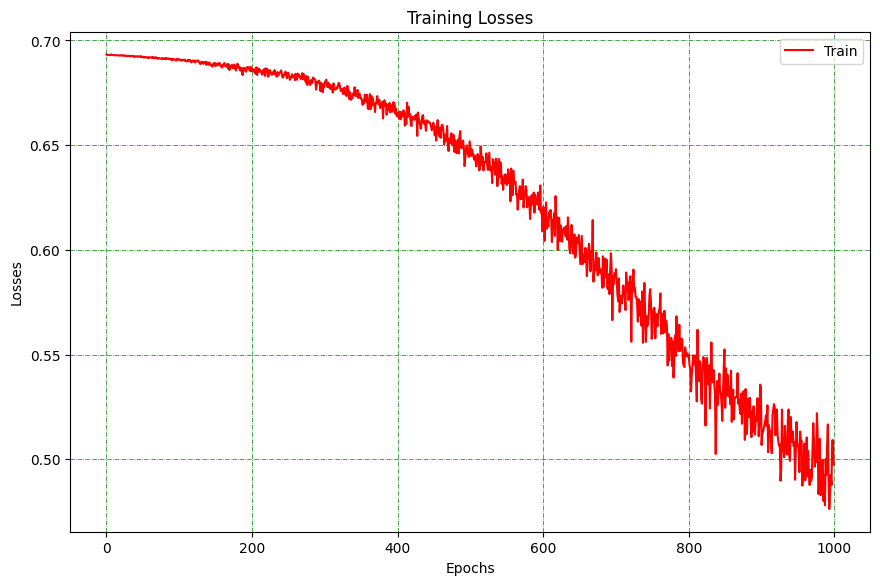

In [ ]:
epochs = range(args['num_epoch'])
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(epochs, train_losses, color='r', label='Train', alpha=1)
ax.grid(color='g', ls='-.', lw=0.5)
ax.set_xlabel('Epochs')
ax.set_ylabel('Losses')
plt.title('Training Losses')
plt.legend()
plt.show()

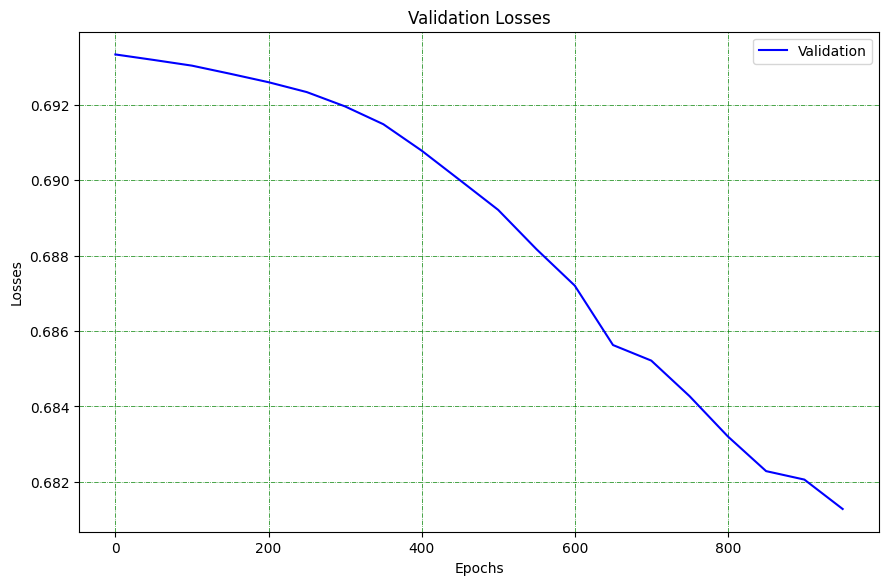

In [ ]:
# the x axes is wrong, but ignore for now
iters = [iter * args['eval_epoch'] for iter in range(len(val_losses))]
epochs = range(args['num_epoch'])
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(iters, val_losses, color='b', label='Validation', alpha=1)
ax.grid(color='g', ls='-.', lw=0.5)
ax.set_xlabel('Epochs')
ax.set_ylabel('Losses')
plt.title('Validation Losses')
plt.legend()
plt.show()


### Evaluate on test set

In [ ]:
model.eval()
test_loss, test_recall, test_precision = evaluation(model, test_edge_index, test_edge_index_sparse, [train_edge_index, val_edge_index], args['topK'], args['lambda'])
print('Evaluation on test set: loss: {:.4f}, recall: {:.4f}, precision: {:.4f}'\
        .format(test_loss, test_recall, test_precision))

Evaluation on test set: loss: 0.5310, recall: 0.0007, precision: 0.0001
